# Module: Interpolation routines for SSP

> Lookup table or interpolation for Simple stellar population (SSPs)

In [ ]:
#| default_exp ssp_interpolation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np

In [ ]:
#| export

def spec_ssp_lookup(age_hydro_i:np.float32=None, # Age of the HACC stellar particle
             metal_hydro_i:np.float32=None, # Metallicity of the stellar particle
             mass_hydro_i:np.float32=None, # Mass of the stellar particle
             age_fsps:np.float32=None, # Ages in SPS library
             z_padova_fsps:np.float32=None, # Metallicities in SPS library
             spec_flux:np.array=None, # Stellar library SEDs 
             spec_wave:np.array=None, # Stellar library wavelengths
            )-> tuple: # SSP Wavelength, SSP Luminosity 
    '''
    Lookup table for finding the closest SPS entry to HACC SSP
    '''
    # https://ned.ipac.caltech.edu/level5/Sept14/Conroy/Conroy2.html
    
    age_index = np.argmin(np.abs(age_fsps-age_hydro_i))
    met_index = np.argmin(np.abs(z_padova_fsps-metal_hydro_i))
    # print(age_index, met_index)
    
    return spec_wave, mass_hydro_i*spec_flux[met_index, age_index]

In [ ]:
#| hide

import matplotlib.pylab as plt
from watercolor.load_sps_library import *
from watercolor.load_sim_stellar_catalog import *

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


Text(0.5, 0, 'age')

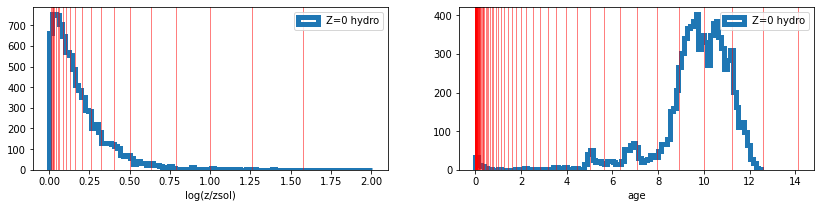

In [ ]:
#| hide

spec_flux, spec_wave = load_fsps_spectral_library()

age_fsps_gyr, Z_padova_fsps = load_fsps_age_metallicity()

gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()


f, a = plt.subplots(1,2, figsize=(14, 3))
a[0].hist(metal_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[0].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in Z_padova_fsps];
a[0].legend()
a[0].set_xlabel('log(z/zsol)')


a[1].hist(age_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[1].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in age_fsps_gyr];
a[1].legend()
a[1].set_xlabel('age')

# plt.savefig('Plots/metal_mass_dist_hydro.png')

In [ ]:
#| hide

ssp_id = 10

spec_wave_ssp, spec_flux_ssp = spec_ssp_lookup(age_hydro[ssp_id], 
             metal_hydro[ssp_id], 
             mass[ssp_id],
             age_fsps_gyr,
             Z_padova_fsps,
             spec_flux,
             spec_wave)

(100.0, 10000.0)

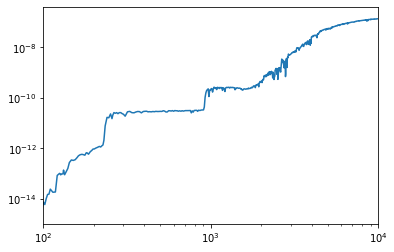

In [ ]:
#| hide

plt.figure()
plt.plot(spec_wave_ssp, spec_flux_ssp)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e4)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()